# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

2024-04-16 00:27:31.673640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 00:27:35.050539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042573

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.229564398219831

### c)

In [8]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [10]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

2024-04-16 00:28:19.078748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 00:28:20.456604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 00:28:20.456869: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 00:28:20.509266: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 00:28:20.509987: I external/local_xla/xla/stream_executor

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [12]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100


I0000 00:00:1713220111.178680  621116 service.cc:145] XLA service 0x7f3efc005890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713220111.179513  621116 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2024-04-16 00:28:31.302018: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-16 00:28:36.499899: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 

I0000 00:00:1713220119.141738  621116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0184 - val_loss: -0.0202
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0202 - val_loss: -0.0444
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0366 - val_loss: -0.0573
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0439 - val_loss: -0.0648
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0543 - val_loss: -0.0699
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0556 - val_loss: -0.0739
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0598 - val_loss: -0.0773
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0644 - val_loss: -0.0802
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: -0.0628 - val_loss: -0.0830
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0724 - val_loss: -0.0856
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: -0.0687 - val_loss: -0.0883
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

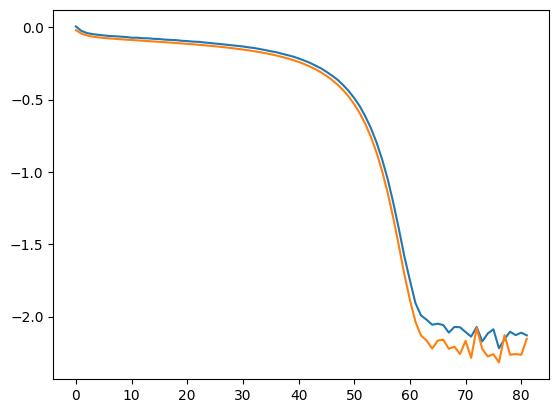

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [14]:
t_x_pred = model.predict(x)[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [15]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

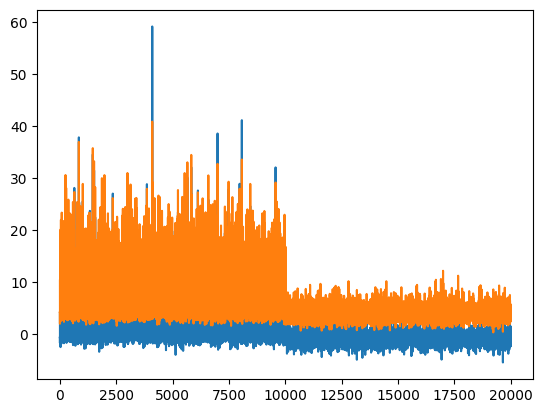

In [16]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

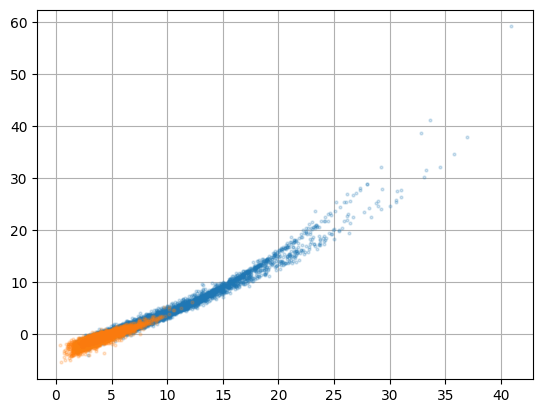

In [17]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

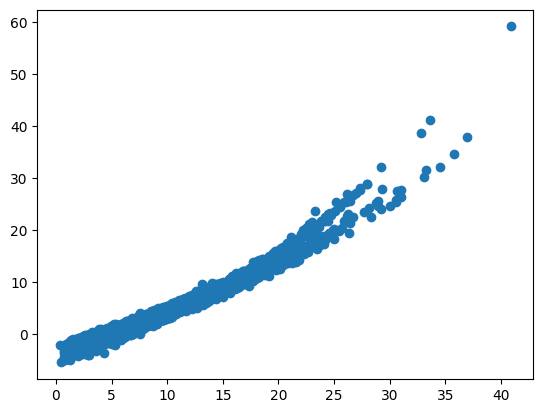

In [18]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [19]:
DV_fun(y, t_x_pred)

2.0593335084713598

In [20]:
DV_fun(y, t_x_opt)

2.229564398219831

In [21]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [22]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [23]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [24]:
DV_fun(y_new, t_x_pred)

1.9885331473729604

In [25]:
DV_fun(y_new, t_x_opt)

2.291375682693541

### f)

In [26]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(tf.subtract(T_x, tf.convert_to_tensor(1.0))), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2
    return -(first_term - second_term)

def NWJ_fun(y, t):
    return np.mean(t[y == 1]) - np.mean(np.exp(t[y == 0] - 1))

In [27]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [29]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: -0.0054 - val_loss: -0.0448
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0493 - val_loss: -0.0566
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0580 - val_loss: -0.0619
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0739 - val_loss: -0.0658
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.0814 - val_loss: -0.0679
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0783 - val_loss: -0.0698
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0937 - val_loss: -0.0722
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0935 - val_loss: -0.0746
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0899 - val_loss: -0.0769
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0978 - val_loss: -0.0787
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.0970 - val_loss: -0.0815
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 

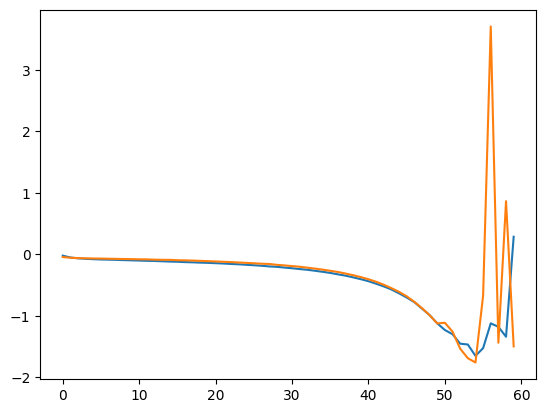

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [31]:
t_x_pred = model.predict(x)[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [32]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

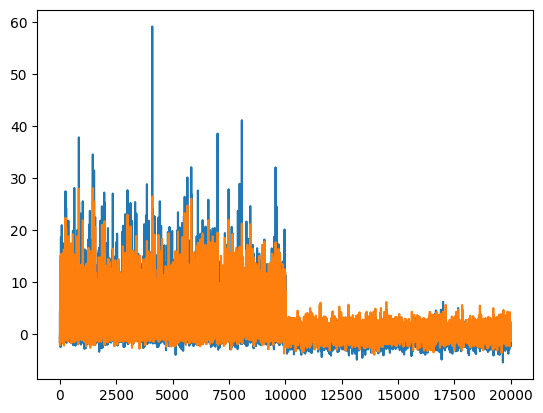

In [33]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)
plt.show()

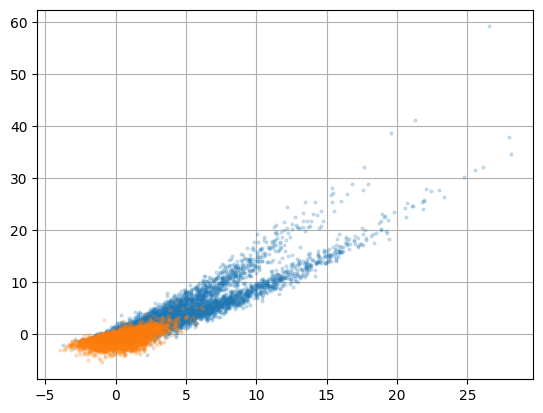

In [34]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

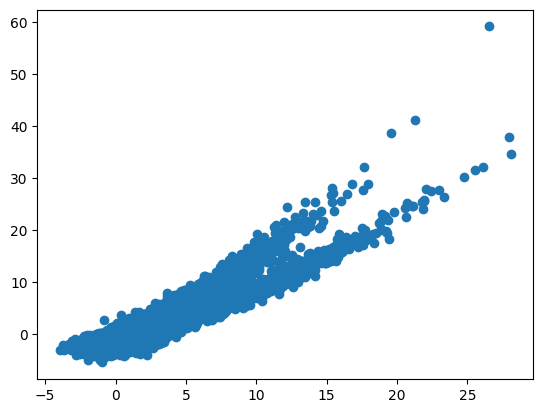

In [35]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [36]:
NWJ_fun(y, t_x_pred)

1.6029334

In [37]:
NWJ_fun(y, t_x_opt)

1.805470447140118

In [38]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [39]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [40]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [41]:
NWJ_fun(y_new, t_x_pred)

1.3370891

In [42]:
NWJ_fun(y_new, t_x_opt)

1.7383562789276357